In [1]:
import utilities
import pandas as pd
import os

If it's the first time we run the code, we'll download the data from bigquery and create a local copy

In [2]:
dataFileName = "data.json"
if (not os.path.exists(dataFileName)):
    df = utilities.retrieveBigQueryData("bigquery-public-data:google_analytics_sample.ga_sessions_20170801")
    df.to_json(dataFileName, orient="records")

Let's import the data

In [3]:
df = pd.read_json(dataFileName)

Let's check the size of the data

In [4]:
print("Rows: ", df.shape[0])
print("Columns: ", df.shape[1])

Rows:  2556
Columns:  16


Let's check the available columns, the types, the number of empty values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   visitorId             0 non-null      float64
 1   visitNumber           2556 non-null   int64  
 2   visitId               2556 non-null   int64  
 3   visitStartTime        2556 non-null   int64  
 4   date                  2556 non-null   int64  
 5   totals                2556 non-null   object 
 6   trafficSource         2556 non-null   object 
 7   device                2556 non-null   object 
 8   geoNetwork            2556 non-null   object 
 9   customDimensions      2556 non-null   object 
 10  hits                  2556 non-null   object 
 11  fullVisitorId         2556 non-null   float64
 12  userId                0 non-null      float64
 13  clientId              0 non-null      float64
 14  channelGrouping       2556 non-null   object 
 15  socialEngagementType 

There are 3 empty columns, related to user id. This is probably due to privacy reasons, since this is a sample dataset.

Let's drop the data.

In [6]:
df.drop(columns=["visitorId", "userId", "clientId"], inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   visitNumber           2556 non-null   int64  
 1   visitId               2556 non-null   int64  
 2   visitStartTime        2556 non-null   int64  
 3   date                  2556 non-null   int64  
 4   totals                2556 non-null   object 
 5   trafficSource         2556 non-null   object 
 6   device                2556 non-null   object 
 7   geoNetwork            2556 non-null   object 
 8   customDimensions      2556 non-null   object 
 9   hits                  2556 non-null   object 
 10  fullVisitorId         2556 non-null   float64
 11  channelGrouping       2556 non-null   object 
 12  socialEngagementType  2556 non-null   object 
dtypes: float64(1), int64(4), object(8)
memory usage: 259.7+ KB


Let's see a sample of the data

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
df.head(3)

,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,channelGrouping,socialEngagementType
0,1,1501583974,1501583974,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Car...",[],"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2.248282e+18,Organic Search,Not Socially Engaged
1,1,1501616585,1501616585,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",8.647436e+18,Organic Search,Not Socially Engaged
2,1,1501583344,1501583344,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Souther...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2.055840e+18,Organic Search,Not Socially Engaged


We see some peculiar features of the data:

- the date column has an improper format
- some columns contain nested objects
- some columns contain lists

Let's clean the date column format. Let's check whethere there are multiple formats in the data

In [10]:
df.date.unique()

array([20170801], dtype=int64)

Let's transform the dates to strings, and add proper formatting

In [11]:
df.date = df.date.map(lambda val: str(val)).map(lambda val: val[0:4] + "-" + val[4:6] + "-" + val[6:8])
df.date.unique()

array(['2017-08-01'], dtype=object)

Let's work on the nested object data, by extracting each object property in a new column.

In [12]:
import utilities
from IPython.display import display

In [13]:
objCols = utilities.getListOfObjectColumns(df)

# Iterate the extraction process until there are no more object-type columns
while (len(objCols) > 0):

    # For each nested column, extract the data in new columns
    for col in objCols:
        print("Original data")
        display(df[[col]].head(3))

        print("Extracted data")
        utilities.extractNestedObjectData(df, col)
        extractedCols = [newcol for newcol in df.columns if newcol.startswith(col)]
        display(df[extractedCols].head(3))
        
        print()
    
    objCols = utilities.getListOfObjectColumns(df)

Original data


,totals
0,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time..."
1,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time..."
2,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time..."


Extracted data


,totals_visits,totals_hits,totals_pageviews,totals_timeOnSite,totals_bounces,totals_transactions,totals_transactionRevenue,totals_newVisits,totals_screenviews,totals_uniqueScreenviews,totals_timeOnScreen,totals_totalTransactionRevenue,totals_sessionQualityDim
0,1,1,1,NaN,1.0,NaN,NaN,1.0,None,None,None,NaN,1
1,1,1,1,NaN,1.0,NaN,NaN,1.0,None,None,None,NaN,1
2,1,1,1,NaN,1.0,NaN,NaN,1.0,None,None,None,NaN,1



Original data


,trafficSource
0,"{'referralPath': None, 'campaign': '(not set)'..."
1,"{'referralPath': None, 'campaign': '(not set)'..."
2,"{'referralPath': None, 'campaign': '(not set)'..."


Extracted data


,trafficSource_referralPath,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_adContent,trafficSource_adwordsClickInfo,trafficSource_isTrueDirect,trafficSource_campaignCode
0,None,(not set),(direct),(none),None,None,"{'campaignId': None, 'adGroupId': None, 'creat...",None,None
1,None,(not set),(direct),(none),None,None,"{'campaignId': None, 'adGroupId': None, 'creat...",None,None
2,None,(not set),(direct),(none),None,None,"{'campaignId': None, 'adGroupId': None, 'creat...",None,None



Original data


,device
0,"{'browser': 'Chrome', 'browserVersion': 'not a..."
1,"{'browser': 'Chrome', 'browserVersion': 'not a..."
2,"{'browser': 'Chrome', 'browserVersion': 'not a..."


Extracted data


,device_browser,device_browserVersion,device_browserSize,device_operatingSystem,device_operatingSystemVersion,device_isMobile,device_mobileDeviceBranding,device_mobileDeviceModel,device_mobileInputSelector,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_flashVersion,device_javaEnabled,device_language,device_screenColors,device_screenResolution,device_deviceCategory
0,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,None,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile
1,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,None,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
2,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,None,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile



Original data


,geoNetwork
0,"{'continent': 'Americas', 'subContinent': 'Car..."
1,"{'continent': 'Americas', 'subContinent': 'Nor..."
2,"{'continent': 'Asia', 'subContinent': 'Souther..."


Extracted data


,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_cityId,geoNetwork_networkDomain,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_networkLocation
0,Americas,Caribbean,St. Lucia,(not set),(not set),(not set),not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset
1,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset
2,Asia,Southern Asia,India,Delhi,(not set),New Delhi,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset



Original data


,trafficSource_adwordsClickInfo
0,"{'campaignId': None, 'adGroupId': None, 'creat..."
1,"{'campaignId': None, 'adGroupId': None, 'creat..."
2,"{'campaignId': None, 'adGroupId': None, 'creat..."


Extracted data


,trafficSource_adwordsClickInfo_campaignId,trafficSource_adwordsClickInfo_adGroupId,trafficSource_adwordsClickInfo_creativeId,trafficSource_adwordsClickInfo_criteriaId,trafficSource_adwordsClickInfo_page,trafficSource_adwordsClickInfo_slot,trafficSource_adwordsClickInfo_criteriaParameters,trafficSource_adwordsClickInfo_gclId,trafficSource_adwordsClickInfo_customerId,trafficSource_adwordsClickInfo_adNetworkType,trafficSource_adwordsClickInfo_targetingCriteria,trafficSource_adwordsClickInfo_isVideoAd
0,None,None,None,None,NaN,None,not available in demo dataset,None,None,None,None,None
1,None,None,None,None,NaN,None,not available in demo dataset,None,None,None,None,None
2,None,None,None,None,NaN,None,not available in demo dataset,None,None,None,None,None



Original data


,trafficSource_adwordsClickInfo_targetingCriteria
0,None
1,None
2,None


Extracted data


,trafficSource_adwordsClickInfo_targetingCriteria_boomUserlistId
0,None
1,None
2,None


Let's see the new size of the dataset

In [14]:
print("Rows: ", df.shape[0])
print("Columns: ", df.shape[1])

Rows:  2556
Columns:  70


Let's check which columns are empty, and remove them

In [15]:
emptycols = []
for col in df.columns:
    if (df[col].isna().all()):
        emptycols.append(col)
print("Empty columns:", emptycols)

Empty columns: ['totals_screenviews', 'totals_uniqueScreenviews', 'totals_timeOnScreen', 'trafficSource_adwordsClickInfo_campaignId', 'trafficSource_adwordsClickInfo_adGroupId', 'trafficSource_adwordsClickInfo_creativeId', 'trafficSource_adwordsClickInfo_criteriaId', 'trafficSource_adwordsClickInfo_customerId', 'trafficSource_adwordsClickInfo_targetingCriteria_boomUserlistId', 'trafficSource_campaignCode', 'device_javaEnabled']


In [16]:
df.drop(columns=emptycols, inplace=True)

In [17]:
print("Rows: ", df.shape[0])
print("Columns: ", df.shape[1])

Rows:  2556
Columns:  59


Let's print a sample of the formatted dataset

In [18]:
df.head()

,visitNumber,visitId,visitStartTime,date,totals_visits,totals_hits,totals_pageviews,totals_timeOnSite,totals_bounces,totals_transactions,totals_transactionRevenue,totals_newVisits,totals_totalTransactionRevenue,totals_sessionQualityDim,trafficSource_referralPath,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_adContent,trafficSource_adwordsClickInfo_page,trafficSource_adwordsClickInfo_slot,trafficSource_adwordsClickInfo_criteriaParameters,trafficSource_adwordsClickInfo_gclId,trafficSource_adwordsClickInfo_adNetworkType,trafficSource_adwordsClickInfo_isVideoAd,trafficSource_isTrueDirect,device_browser,device_browserVersion,device_browserSize,device_operatingSystem,device_operatingSystemVersion,device_isMobile,device_mobileDeviceBranding,device_mobileDeviceModel,device_mobileInputSelector,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_flashVersion,device_language,device_screenColors,device_screenResolution,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_cityId,geoNetwork_networkDomain,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_networkLocation,customDimensions,hits,fullVisitorId,channelGrouping,socialEngagementType
0,1,1501583974,1501583974,2017-08-01,1,1,1,NaN,1.0,NaN,NaN,1.0,NaN,1,None,(not set),(direct),(none),None,None,NaN,None,not available in demo dataset,None,None,None,None,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Americas,Caribbean,St. Lucia,(not set),(not set),(not set),not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,[],"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2.248282e+18,Organic Search,Not Socially Engaged
1,1,1501616585,1501616585,2017-08-01,1,1,1,NaN,1.0,NaN,NaN,1.0,NaN,1,None,(not set),(direct),(none),None,None,NaN,None,not available in demo dataset,None,None,None,None,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,"[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",8.647436e+18,Organic Search,Not Socially Engaged
2,1,1501583344,1501583344,2017-08-01,1,1,1,NaN,1.0,NaN,NaN,1.0,NaN,1,None,(not set),(direct),(none),None,None,NaN,None,not available in demo dataset,None,None,None,None,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Asia,Southern Asia,India,Delhi,(not set),New Delhi,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,"[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2.055840e+18,Organic Search,Not Socially En

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 59 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   visitNumber                                        2556 non-null   int64  
 1   visitId                                            2556 non-null   int64  
 2   visitStartTime                                     2556 non-null   int64  
 3   date                                               2556 non-null   object 
 4   totals_visits                                      2556 non-null   int64  
 5   totals_hits                                        2556 non-null   int64  
 6   totals_pageviews                                   2556 non-null   int64  
 7   totals_timeOnSite                                  1310 non-null   float64
 8   totals_bounces                                     1238 non-null   float64
 9   totals_t

Let's move on to extracting the data in the array-type columns

In [20]:
arrayCols = utilities.getListOfArrayColumns(df)
arrayCols

['customDimensions', 'hits']

In [21]:
df[arrayCols].head()

,customDimensions,hits
0,[],"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut..."
1,"[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu..."
2,"[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut..."
3,"[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 0, 'minut..."
4,"[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 22, 'minu..."


Let's check the number of values per array in each column

In [22]:
for col in arrayCols:
    print(col)
    lengths = df[col].map(lambda list: 0 if list == None else len(list)).unique()
    print(lengths, "\n")

customDimensions
[0 1] 

hits
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  32  33  34  35  36  37
  38  39  42  44  45  47  48  53  55  58  60  62  63  64  71  78  80  81
  82  84 100 140 156 193 302] 



Each cell in the ```custom``` contains either 0 or 1 object value, so we can simply extract the object in it and read its' nested data.

In [23]:
df.customDimensions = df.customDimensions.map(lambda list: None if (list == None or len(list) == 0) else list[0])

In [24]:
df[["customDimensions"]].head()

,customDimensions
0,None
1,"{'index': 4, 'value': 'North America'}"
2,"{'index': 4, 'value': 'APAC'}"
3,"{'index': 4, 'value': 'EMEA'}"
4,"{'index': 4, 'value': 'North America'}"


In [25]:
utilities.extractNestedObjectData(df, "customDimensions")

In [26]:
df.head()

,visitNumber,visitId,visitStartTime,date,totals_visits,totals_hits,totals_pageviews,totals_timeOnSite,totals_bounces,totals_transactions,totals_transactionRevenue,totals_newVisits,totals_totalTransactionRevenue,totals_sessionQualityDim,trafficSource_referralPath,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_adContent,trafficSource_adwordsClickInfo_page,trafficSource_adwordsClickInfo_slot,trafficSource_adwordsClickInfo_criteriaParameters,trafficSource_adwordsClickInfo_gclId,trafficSource_adwordsClickInfo_adNetworkType,trafficSource_adwordsClickInfo_isVideoAd,trafficSource_isTrueDirect,device_browser,device_browserVersion,device_browserSize,device_operatingSystem,device_operatingSystemVersion,device_isMobile,device_mobileDeviceBranding,device_mobileDeviceModel,device_mobileInputSelector,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_flashVersion,device_language,device_screenColors,device_screenResolution,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_cityId,geoNetwork_networkDomain,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_networkLocation,customDimensions_index,customDimensions_value,hits,fullVisitorId,channelGrouping,socialEngagementType
0,1,1501583974,1501583974,2017-08-01,1,1,1,NaN,1.0,NaN,NaN,1.0,NaN,1,None,(not set),(direct),(none),None,None,NaN,None,not available in demo dataset,None,None,None,None,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Americas,Caribbean,St. Lucia,(not set),(not set),(not set),not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,NaN,None,"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2.248282e+18,Organic Search,Not Socially Engaged
1,1,1501616585,1501616585,2017-08-01,1,1,1,NaN,1.0,NaN,NaN,1.0,NaN,1,None,(not set),(direct),(none),None,None,NaN,None,not available in demo dataset,None,None,None,None,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,4.0,North America,"[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",8.647436e+18,Organic Search,Not Socially Engaged
2,1,1501583344,1501583344,2017-08-01,1,1,1,NaN,1.0,NaN,NaN,1.0,NaN,1,None,(not set),(direct),(none),None,None,NaN,None,not available in demo dataset,None,None,None,None,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Asia,Southern Asia,India,Delhi,(not set),New Delhi,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,4.0,APAC,"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2.055840e+18,Organic Search,Not Socially Engaged
3,1,15015

For the ```hits``` column we'll need to export the data to a separate dataset, otherwise to extract it we'd multiply the number of rows in the original dataset.

Let's add an ID column to the base dataset, to link it with the hits dataset.

In [27]:
df = df.reset_index().rename(columns={"index": "id"})
df.head()

,id,visitNumber,visitId,visitStartTime,date,totals_visits,totals_hits,totals_pageviews,totals_timeOnSite,totals_bounces,totals_transactions,totals_transactionRevenue,totals_newVisits,totals_totalTransactionRevenue,totals_sessionQualityDim,trafficSource_referralPath,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_adContent,trafficSource_adwordsClickInfo_page,trafficSource_adwordsClickInfo_slot,trafficSource_adwordsClickInfo_criteriaParameters,trafficSource_adwordsClickInfo_gclId,trafficSource_adwordsClickInfo_adNetworkType,trafficSource_adwordsClickInfo_isVideoAd,trafficSource_isTrueDirect,device_browser,device_browserVersion,device_browserSize,device_operatingSystem,device_operatingSystemVersion,device_isMobile,device_mobileDeviceBranding,device_mobileDeviceModel,device_mobileInputSelector,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_flashVersion,device_language,device_screenColors,device_screenResolution,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_cityId,geoNetwork_networkDomain,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_networkLocation,customDimensions_index,customDimensions_value,hits,fullVisitorId,channelGrouping,socialEngagementType
0,0,1,1501583974,1501583974,2017-08-01,1,1,1,NaN,1.0,NaN,NaN,1.0,NaN,1,None,(not set),(direct),(none),None,None,NaN,None,not available in demo dataset,None,None,None,None,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Americas,Caribbean,St. Lucia,(not set),(not set),(not set),not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,NaN,None,"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2.248282e+18,Organic Search,Not Socially Engaged
1,1,1,1501616585,1501616585,2017-08-01,1,1,1,NaN,1.0,NaN,NaN,1.0,NaN,1,None,(not set),(direct),(none),None,None,NaN,None,not available in demo dataset,None,None,None,None,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,4.0,North America,"[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",8.647436e+18,Organic Search,Not Socially Engaged
2,2,1,1501583344,1501583344,2017-08-01,1,1,1,NaN,1.0,NaN,NaN,1.0,NaN,1,None,(not set),(direct),(none),None,None,NaN,None,not available in demo dataset,None,None,None,None,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Asia,Southern Asia,India,Delhi,(not set),New Delhi,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,4.0,APAC,"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2.055840e+18,Organic Search,Not Socially Engaged


In [28]:
hitsdf = df[["id", "hits"]].rename(columns={"id": "session_id"})
hitsdf.head()

,session_id,hits
0,0,"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut..."
1,1,"[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu..."
2,2,"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut..."
3,3,"[{'hitNumber': 1, 'time': 0, 'hour': 0, 'minut..."
4,4,"[{'hitNumber': 1, 'time': 0, 'hour': 22, 'minu..."


In [29]:
df.drop(columns="hits", inplace=True)

Now that we've flattened and formatted the base dataset, let's perform further exploration.

Let's display some descriptive statistics.

In [30]:
# Quantitative columns
display(df.describe())

# Qualitative columns
display(df.describe(include=object))

,id,visitNumber,visitId,visitStartTime,totals_visits,totals_hits,totals_pageviews,totals_timeOnSite,totals_bounces,totals_transactions,totals_transactionRevenue,totals_newVisits,totals_totalTransactionRevenue,totals_sessionQualityDim,trafficSource_adwordsClickInfo_page,customDimensions_index,fullVisitorId
count,2556.000000,2556.000000,2.556000e+03,2.556000e+03,2556.0,2556.000000,2556.000000,1310.000000,1238.0,43.000000,4.300000e+01,1872.0,4.300000e+01,2556.000000,58.0,2210.0,2.556000e+03
mean,1277.500000,2.661189,1.501614e+09,1.501614e+09,1.0,5.177230,4.279734,325.051908,1.0,1.046512,1.931381e+08,1.0,2.067442e+08,5.832942,1.0,4.0,4.549451e+18
std,737.997967,12.022200,2.280455e+04,2.280423e+04,0.0,11.816349,7.966343,592.411724,0.0,0.213083,4.787008e+08,0.0,4.785247e+08,16.463750,0.0,0.0,3.107969e+18
min,0.000000,1.000000,1.501570e+09,1.501571e+09,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.990000e+06,1.0,2.990000e+06,1.000000,1.0,4.0,3.458418e+15
25%,638.750000,1.000000,1.501597e+09,1.501597e+09,1.0,1.000000,1.000000,32.000000,1.0,1.000000,2.918500e+07,1.0,3.439500e+07,1.000000,1.0,4.0,1.627093e+18
50%,1277.500000,1.000000,1.501614e+09,1.501614e+09,1.0,2.000000,2.000000,96.500000,1.0,1.000000,4.567000e+07,1.0,5.079000e+07,1.000000,1.0,4.0,4.466389e+18
75%,1916.250000,2.000000,1.501632e+09,1.501632e+09,1.0,5.000000,4.000000,336.750000,1.0,1.000000,1.509150e+08,1.0,1.695200e+08,1.000000,1.0,4.0,7.350971e+18
max,2555.000000,326.000000,1.501657e+09,1.501657e+09,1.0,302.000000,155.000000,5455.000000,1.0,2.000000,2.933610e+09,1.0,2.935610e+09,95.000000,1.0,4.0,9.997536e+18


,date,trafficSource_referralPath,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_adContent,trafficSource_adwordsClickInfo_slot,trafficSource_adwordsClickInfo_criteriaParameters,trafficSource_adwordsClickInfo_gclId,trafficSource_adwordsClickInfo_adNetworkType,trafficSource_adwordsClickInfo_isVideoAd,trafficSource_isTrueDirect,device_browser,device_browserVersion,device_browserSize,device_operatingSystem,device_operatingSystemVersion,device_mobileDeviceBranding,device_mobileDeviceModel,device_mobileInputSelector,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_flashVersion,device_language,device_screenColors,device_screenResolution,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_cityId,geoNetwork_networkDomain,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_networkLocation,customDimensions_value,channelGrouping,socialEngagementType
count,2556,649,2556,2556,2556,5,12,58,2556,58,58,58,872,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2210,2556,2556
unique,1,88,2,35,5,3,2,1,1,52,1,1,1,15,1,1,9,1,1,1,1,1,1,1,1,1,1,3,6,19,94,42,19,56,1,524,1,1,1,5,7,1
top,2017-08-01,/,(not set),(direct),(none),(not provided),Display Ad created 3/11/14,Top,not available in demo dataset,CjwKCAjwzYDMBRA1EiwAwCv6Jt0kCNNM8qAVQ6PaGsphV9...,Google Search,False,True,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,North America,Organic Search,Not Socially Engaged
freq,2556,330,2504,2166,2166,3,11,58,2556,4,58,58,872,1900,2556,2556,834,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,1742,1472,1372,1287,1388,1388,1388,2556,1003,2556,2556,2556,1372,1346,2556


By observing the data, we can identify some columns of little interest from an analytics standpoint.

Let's remove them.

In [31]:
colsToDelete = [
    "visitNumber", "visitId", "visitStartTime", "totals_visits", "totals_bounces", "totals_transactions", 
    "totals_transactionRevenue", "totals_newVisits", "totals_totalTransactionRevenue", "totals_sessionQualityDim",
    "customDimensions_index", "customDimensions_value", "trafficSource_adwordsClickInfo_gclId",
    "device_browserSize", "device_mobileDeviceBranding", "device_mobileInputSelector", "device_mobileDeviceMarketingName",
    "device_flashVersion", "device_isMobile", "device_mobileDeviceInfo", "device_screenColors", "device_screenResolution", "geoNetwork_latitude", "geoNetwork_longitude",
    "geoNetwork_networkLocation", "trafficSource_adwordsClickInfo_page"
]
df.drop(columns=colsToDelete, inplace=True)

In [32]:
print("Rows: ", df.shape[0])
print("Columns: ", df.shape[1])

Rows:  2556
Columns:  34


Let's print again the statistics now that we have fewer data to get a clearer picture

In [33]:
# Quantitative columns
display(df.describe())

# Qualitative columns
display(df.describe(include=object))

,id,totals_hits,totals_pageviews,totals_timeOnSite,fullVisitorId
count,2556.000000,2556.000000,2556.000000,1310.000000,2.556000e+03
mean,1277.500000,5.177230,4.279734,325.051908,4.549451e+18
std,737.997967,11.816349,7.966343,592.411724,3.107969e+18
min,0.000000,1.000000,1.000000,1.000000,3.458418e+15
25%,638.750000,1.000000,1.000000,32.000000,1.627093e+18
50%,1277.500000,2.000000,2.000000,96.500000,4.466389e+18
75%,1916.250000,5.000000,4.000000,336.750000,7.350971e+18
max,2555.000000,302.000000,155.000000,5455.000000,9.997536e+18


,date,trafficSource_referralPath,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_adContent,trafficSource_adwordsClickInfo_slot,trafficSource_adwordsClickInfo_criteriaParameters,trafficSource_adwordsClickInfo_adNetworkType,trafficSource_adwordsClickInfo_isVideoAd,trafficSource_isTrueDirect,device_browser,device_browserVersion,device_operatingSystem,device_operatingSystemVersion,device_mobileDeviceModel,device_language,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,geoNetwork_cityId,geoNetwork_networkDomain,channelGrouping,socialEngagementType
count,2556,649,2556,2556,2556,5,12,58,2556,58,58,872,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556,2556
unique,1,88,2,35,5,3,2,1,1,1,1,1,15,1,9,1,1,1,3,6,19,94,42,19,56,1,524,7,1
top,2017-08-01,/,(not set),(direct),(none),(not provided),Display Ad created 3/11/14,Top,not available in demo dataset,Google Search,False,True,Chrome,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),Organic Search,Not Socially Engaged
freq,2556,330,2504,2166,2166,3,11,58,2556,58,58,872,1900,2556,834,2556,2556,2556,1742,1472,1372,1287,1388,1388,1388,2556,1003,1346,2556


Let's plot the numerical data

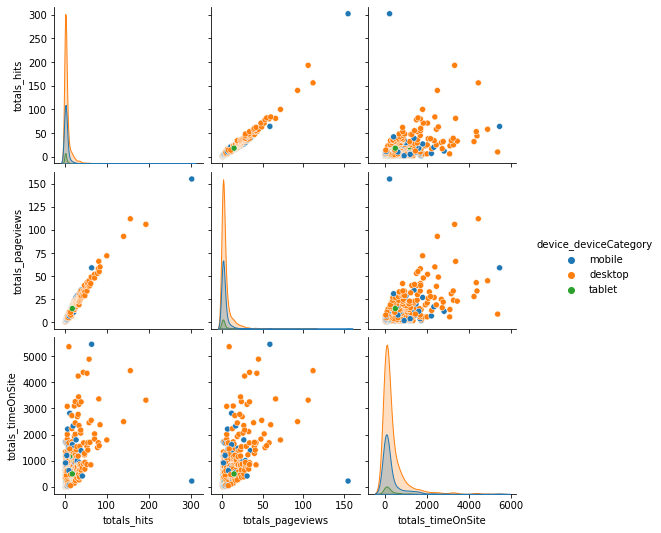

In [34]:
import seaborn as sns
sns.pairplot(df.drop(columns=["id", "fullVisitorId"]), hue="device_deviceCategory")

<AxesSubplot:title={'center':'Correlations\n'}>

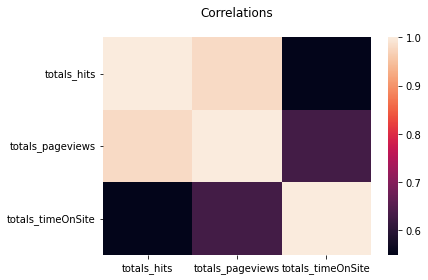

In [35]:
import matplotlib.pyplot as plt
import numpy as np
plt.title("Correlations\n")
sns.heatmap(df.drop(columns=["id", "fullVisitorId"]).select_dtypes(include=np.number).corr())

Let's explore the categorical data.

First, let's see how the different types of user devices are distributed.

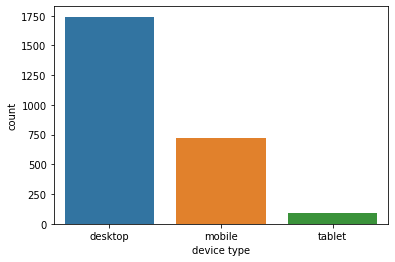

In [36]:
ax = sns.countplot(data=df, x="device_deviceCategory", order=df.device_deviceCategory.value_counts().index)
ax.set(xlabel="device type")
plt.show()

Let's see how the time spent by the user on the site relates to the device type. We'd expect longer average stay time on desktop devices.

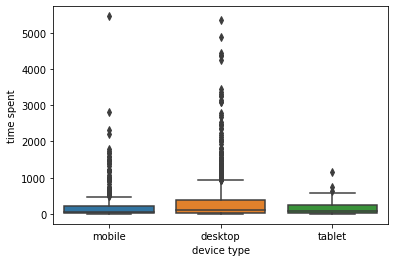

In [37]:
ax = sns.boxplot(data=df, x="device_deviceCategory", y="totals_timeOnSite")
ax.set(xlabel="device type", ylabel="time spent")
plt.show()

Let's check the most common regions

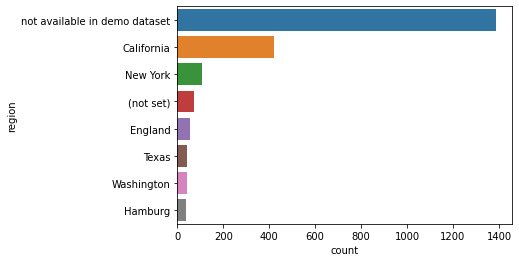

In [53]:
numRegionsToShow = 8

ax = sns.countplot(data=df, y="geoNetwork_region", order=df.geoNetwork_region.value_counts()[:numRegionsToShow].index)
ax.set(ylabel="region", xlabel="count")
plt.show()

Let's explore the hits dataset

In [39]:
print("Rows: ", hitsdf.shape[0])
print("Columns: ", hitsdf.shape[1])

Rows:  2556
Columns:  2


In [40]:
hitsdf.head()

,session_id,hits
0,0,"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut..."
1,1,"[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu..."
2,2,"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut..."
3,3,"[{'hitNumber': 1, 'time': 0, 'hour': 0, 'minut..."
4,4,"[{'hitNumber': 1, 'time': 0, 'hour': 22, 'minu..."


Let's unpack the data

In [41]:
hitsdf = pd.merge(hitsdf.session_id, hitsdf.hits.explode(), left_index=True, right_index=True)
hitsdf.head()

,session_id,hits
0,0,"{'hitNumber': 1, 'time': 0, 'hour': 3, 'minute..."
1,1,"{'hitNumber': 1, 'time': 0, 'hour': 12, 'minut..."
2,2,"{'hitNumber': 1, 'time': 0, 'hour': 3, 'minute..."
3,3,"{'hitNumber': 1, 'time': 0, 'hour': 0, 'minute..."
4,4,"{'hitNumber': 1, 'time': 0, 'hour': 22, 'minut..."


In [42]:
print("Rows: ", hitsdf.shape[0])
print("Columns: ", hitsdf.shape[1])

Rows:  13233
Columns:  2


Let's extract the nested data in the hits column

In [43]:
objCols = utilities.getListOfObjectColumns(hitsdf)
while (len(objCols) > 0):
    for col in objCols:
        utilities.extractNestedObjectData(hitsdf, col)
    objCols = utilities.getListOfObjectColumns(hitsdf)

hitsdf.head()

,session_id,hits_hitNumber,hits_time,hits_hour,hits_minute,hits_isSecure,hits_isInteraction,hits_isEntrance,hits_isExit,hits_referer,hits_page_pagePath,hits_page_hostname,hits_page_pageTitle,hits_page_searchKeyword,hits_page_searchCategory,hits_page_pagePathLevel1,hits_page_pagePathLevel2,hits_page_pagePathLevel3,hits_page_pagePathLevel4,hits_transaction_transactionId,hits_transaction_transactionRevenue,hits_transaction_transactionTax,hits_transaction_transactionShipping,hits_transaction_affiliation,hits_transaction_currencyCode,hits_transaction_localTransactionRevenue,hits_transaction_localTransactionTax,hits_transaction_localTransactionShipping,hits_transaction_transactionCoupon,hits_item_transactionId,hits_item_productName,hits_item_productCategory,hits_item_productSku,hits_item_itemQuantity,hits_item_itemRevenue,hits_item_currencyCode,hits_item_localItemRevenue,hits_contentInfo,hits_appInfo_name,hits_appInfo_version,hits_appInfo_id,hits_appInfo_installerId,hits_appInfo_appInstallerId,hits_appInfo_appName,hits_appInfo_appVersion,hits_appInfo_appId,hits_appInfo_screenName,hits_appInfo_landingScreenName,hits_appInfo_exitScreenName,hits_appInfo_screenDepth,hits_exceptionInfo_description,hits_exceptionInfo_isFatal,hits_exceptionInfo_exceptions,hits_exceptionInfo_fatalExceptions,hits_eventInfo,hits_product,hits_promotion,hits_promotionActionInfo_promoIsView,hits_promotionActionInfo_promoIsClick,hits_refund,hits_eCommerceAction_action_type,hits_eCommerceAction_step,hits_eCommerceAction_option,hits_experiment,hits_publisher,hits_customVariables,hits_customDimensions,hits_customMetrics,hits_type,hits_social_socialInteractionNetwork,hits_social_socialInteractionAction,hits_social_socialInteractions,hits_social_socialInteractionTarget,hits_social_socialNetwork,hits_social_uniqueSocialInteractions,hits_social_hasSocialSourceReferral,hits_social_socialInteractionNetworkAction,hits_latencyTracking,hits_sourcePropertyInfo,hits_contentGroup_contentGroup1,hits_contentGroup_contentGroup2,hits_contentGroup_contentGroup3,hits_contentGroup_contentGroup4,hits_contentGroup_contentGroup5,hits_contentGroup_previousContentGroup1,hits_contentGroup_previousContentGroup2,hits_contentGroup_previousContentGroup3,hits_contentGroup_previousContentGroup4,hits_contentGroup_previousContentGroup5,hits_contentGroup_contentGroupUniqueViews1,hits_contentGroup_contentGroupUniqueViews2,hits_contentGroup_contentGroupUniqueViews3,hits_contentGroup_contentGroupUniqueViews4,hits_contentGroup_contentGroupUniqueViews5,hits_dataSource,hits_publisher_infos
0,0,1,0,3,39,None,True,True,True,http://www.google.com/,/google+redesign/electronics,shop.googlemerchandisestore.com,Electronics | Google Merchandise Store,None,None,/google+redesign/,/electronics,,,None,NaN,NaN,NaN,None,USD,NaN,NaN,NaN,None,None,None,None,None,None,None,USD,None,None,None,None,None,None,None,None,None,None,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/google+redesig...,0,None,True,None,None,None,"[{'productSKU': 'GGOEGBFC018799', 'v2ProductNa...",[],None,None,None,0,1,None,[],None,[],[],[],PAGE,None,None,None,None,(not set),None,No,:,None,None,(not set),Electronics,(not set),(not set),(not set),(entrance),(entrance),(entrance),(entrance),(entrance),NaN,1.0,NaN,None,None,web,[]
1,1,1,0,12,43,None,True,True,True,https://www.google.com/,/google+redesign/apparel/mens/mens+outerwear,shop.googlemerchandisestore.com,Men's Outerwear | Apparel | Google Merchandise...,None,None,/google+redesign/,/apparel/,/mens/,/mens+outerwear,None,NaN,NaN,NaN,None,USD,NaN,NaN,NaN,None,None,None,None,None,None,None,USD,None,None,None,None,None,None,None,None,None,None,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/google+redesig...,0,None,True,None,None,None,"[{'productSKU': 'GGOEGAAX0313', 'v2ProductName...",[],None,None,None,0,1,None,[],None,[],[],[],PAGE,No

Let's check the new columns

In [44]:
hitsdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13233 entries, 0 to 2555
Data columns (total 96 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   session_id                                  13233 non-null  int64  
 1   hits_hitNumber                              13233 non-null  int64  
 2   hits_time                                   13233 non-null  int64  
 3   hits_hour                                   13233 non-null  int64  
 4   hits_minute                                 13233 non-null  int64  
 5   hits_isSecure                               0 non-null      object 
 6   hits_isInteraction                          13233 non-null  bool   
 7   hits_isEntrance                             2556 non-null   object 
 8   hits_isExit                                 2556 non-null   object 
 9   hits_referer                                2817 non-null   object 
 10  hits_page_p

Let's remove the empty data

In [47]:
colsToDrop = []
for col in hitsdf.columns:
    if (hitsdf[col].isnull().all()):
        colsToDrop.append(col)
print(colsToDrop)
hitsdf.drop(columns=colsToDrop, inplace=True)

['hits_transaction_transactionCoupon', 'hits_item_productName', 'hits_item_productCategory', 'hits_item_productSku', 'hits_item_itemQuantity', 'hits_item_itemRevenue', 'hits_item_localItemRevenue', 'hits_contentInfo', 'hits_appInfo_name', 'hits_appInfo_version', 'hits_appInfo_id', 'hits_appInfo_installerId', 'hits_appInfo_appInstallerId', 'hits_appInfo_appName', 'hits_appInfo_appVersion', 'hits_appInfo_appId', 'hits_exceptionInfo_description', 'hits_exceptionInfo_exceptions', 'hits_exceptionInfo_fatalExceptions', 'hits_refund', 'hits_publisher', 'hits_social_socialInteractionNetwork', 'hits_social_socialInteractionAction', 'hits_social_socialInteractions', 'hits_social_socialInteractionTarget', 'hits_social_uniqueSocialInteractions', 'hits_sourcePropertyInfo', 'hits_contentGroup_contentGroupUniqueViews4', 'hits_contentGroup_contentGroupUniqueViews5']


In [48]:
print("Rows: ", hitsdf.shape[0])
print("Columns: ", hitsdf.shape[1])

Rows:  13233
Columns:  66


Let's explore the descriptive statistics

In [49]:
# Quantitative columns
display(hitsdf.describe())

# Qualitative columns
display(hitsdf.describe(include=object))

,session_id,hits_hitNumber,hits_time,hits_hour,hits_minute,hits_transaction_transactionRevenue,hits_transaction_transactionTax,hits_transaction_transactionShipping,hits_transaction_localTransactionRevenue,hits_transaction_localTransactionTax,hits_transaction_localTransactionShipping,hits_eCommerceAction_step,hits_contentGroup_contentGroupUniqueViews1,hits_contentGroup_contentGroupUniqueViews2,hits_contentGroup_contentGroupUniqueViews3
count,13233.000000,13233.000000,1.323300e+04,13233.000000,13233.000000,4.500000e+01,3.600000e+01,4.500000e+01,4.500000e+01,3.600000e+01,4.500000e+01,13233.000000,157.0,2679.0,75.0
mean,1952.150911,16.580821,3.720854e+05,12.502834,29.305751,1.978222e+08,1.770167e+07,2.093978e+07,1.978222e+08,1.770167e+07,2.093978e+07,1.017079,1.0,1.0,1.0
std,524.643375,32.390962,6.636080e+05,5.761706,17.562832,4.676024e+08,1.858622e+07,4.998690e+07,4.676024e+08,1.858622e+07,4.998690e+07,0.156514,0.0,0.0,0.0
min,0.000000,1.000000,0.000000e+00,0.000000,0.000000,2.990000e+06,1.640000e+06,7.000000e+06,2.990000e+06,1.640000e+06,7.000000e+06,1.000000,1.0,1.0,1.0
25%,1817.000000,2.000000,1.322100e+04,9.000000,14.000000,3.479000e+07,8.025000e+06,9.000000e+06,3.479000e+07,8.025000e+06,9.000000e+06,1.000000,1.0,1.0,1.0
50%,2161.000000,6.000000,1.068400e+05,13.000000,29.000000,5.079000e+07,1.147000e+07,1.200000e+07,5.079000e+07,1.147000e+07,1.200000e+07,1.000000,1.0,1.0,1.0
75%,2300.000000,16.000000,4.167030e+05,17.000000,45.000000,1.651400e+08,2.007750e+07,1.648000e+07,1.651400e+08,2.007750e+07,1.648000e+07,1.000000,1.0,1.0,1.0
max,2555.000000,302.000000,5.454983e+06,23.000000,59.000000,2.935610e+09,9.665000e+07,3.467800e+08,2.935610e+09,9.665000e+07,3.467800e+08,3.000000,1.0,1.0,1.0


,hits_isEntrance,hits_isExit,hits_referer,hits_page_pagePath,hits_page_hostname,hits_page_pageTitle,hits_page_searchKeyword,hits_page_searchCategory,hits_page_pagePathLevel1,hits_page_pagePathLevel2,hits_page_pagePathLevel3,hits_page_pagePathLevel4,hits_transaction_transactionId,hits_transaction_affiliation,hits_transaction_currencyCode,hits_item_transactionId,hits_item_currencyCode,hits_appInfo_screenName,hits_appInfo_landingScreenName,hits_appInfo_exitScreenName,hits_appInfo_screenDepth,hits_eventInfo,hits_product,hits_promotion,hits_promotionActionInfo_promoIsView,hits_promotionActionInfo_promoIsClick,hits_eCommerceAction_action_type,hits_eCommerceAction_option,hits_experiment,hits_customVariables,hits_customDimensions,hits_customMetrics,hits_type,hits_social_socialNetwork,hits_social_hasSocialSourceReferral,hits_social_socialInteractionNetworkAction,hits_latencyTracking,hits_contentGroup_contentGroup1,hits_contentGroup_contentGroup2,hits_contentGroup_contentGroup3,hits_contentGroup_contentGroup4,hits_contentGroup_contentGroup5,hits_contentGroup_previousContentGroup1,hits_contentGroup_previousContentGroup2,hits_contentGroup_previousContentGroup3,hits_contentGroup_previousContentGroup4,hits_contentGroup_previousContentGroup5,hits_dataSource,hits_publisher_infos
count,2556,2556,2817,13233,13233,13219,4,4,13233,13233,13233,13233,92,92,6226,92,6226,13233,13233,13233,13233,2265,13233,13233,1618,2,13233,330,13233,13233,13233,13233,13233,13233,13233,13233,29,13233,13233,13233,13233,13233,13233,13233,13233,13233,13233,13233,13233
unique,1,1,284,314,2,249,1,1,29,31,112,180,43,1,1,43,1,315,122,191,1,179,2047,4,1,1,7,3,1,1,1,1,2,8,2,1,28,4,9,2,1,1,5,10,3,2,2,2,1
top,True,True,https://www.google.com/,/home,shop.googlemerchandisestore.com,Home,gopher,(not set),/google+redesign/,,,,ORD201708012585,Google Merchandise Store,USD,ORD201708012585,USD,shop.googlemerchandisestore.com/home,shop.googlemerchandisestore.com/home,shop.googlemerchandisestore.com/ordercompleted...,0,"{'eventCategory': 'Enhanced Ecommerce', 'event...",[],[],True,True,0,Billing and Shipping,[],[],[],[],PAGE,(not set),No,:,"{'pageLoadSample': 1.0, 'pageLoadTime': 4175.0...",(not set),(not set),(not set),(not set),(not set),(not set),Apparel,(not set),(not set),(not set),web,[]
freq,2556,2556,778,2225,12488,1622,4,4,7976,4906,6259,9578,4,92,6226,4,6226,1480,4495,1190,13233,494,4175,11613,1618,2,9299,155,13233,13233,13233,13233,10939,12801,12801,13233,2,12984,5370,13080,13233,13233,10452,3115,10431,10677,10677,13217,13233


Let's explore the most viewed pages

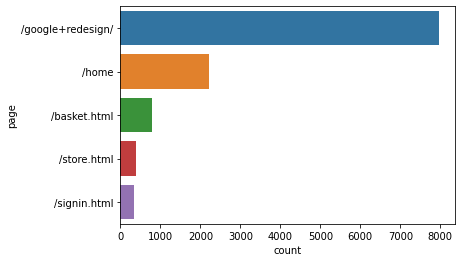

In [54]:
numDataToShow = 5

ax = sns.countplot(data=hitsdf, y="hits_page_pagePathLevel1", order=hitsdf.hits_page_pagePathLevel1.value_counts()[:numDataToShow].index)
ax.set(ylabel="page", xlabel="count")
plt.show()